In [2]:
# Import all required toolkits
import os
import glob
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sn

# Cleaning

In [22]:
from sklearn.utils import shuffle

# Read all files in a given subfolder as a labelled dataframe
def readFiles (path, label):
    reviews = [open(filename, 'r', encoding='utf-8').read() for filename in glob.glob('aclImdb/' + path + '/*.txt')]
    # Movie review filename is id_rate.txt so we extract rate from it
    rates = [int(os.path.splitext(filename)[0].split('_')[1]) for filename in glob.glob('aclImdb/' + path + '/*.txt')]
    return pd.DataFrame({ 'label': label, 'review': reviews, 'rate': rates })

# Read train dataset and shuffle data to avoid having all positive first then negative ones
train_data = shuffle(pd.concat([
    readFiles('train/pos', 'positive'),
    readFiles('train/neg', 'negative')
]))
train_data.head()

,label,review,rate
971,positive,Australia's first mainstream slasher film hits...,8
237,negative,"A lot of people seemed to have liked the film,...",1
3515,negative,"it aint bad, but it aint good. it is just ente...",4
3804,positive,"I think I truly love this film . ""Prix de Beau...",8
11431,negative,"A noble effort, I guess, but ultimately a poor...",4


Negative summary
              rate
count  12500.00000
mean       2.21696
std        1.19053
min        1.00000
25%        1.00000
50%        2.00000
75%        3.00000
max        4.00000
Positive summary
               rate
count  12500.000000
mean       8.738480
std        1.161772
min        7.000000
25%        8.000000
50%        9.000000
75%       10.000000
max       10.000000


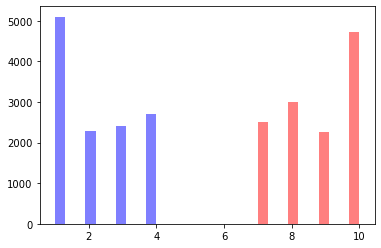

In [29]:
# Get some insight about the data
print('Negative summary')
print(train_data[train_data['label'] == 'negative'].describe())
print('Positive summary')
print(train_data[train_data['label'] == 'positive'].describe())
plt.hist(train_data[train_data['label'] == 'negative']['rate'], facecolor='b', alpha=0.5, label='negative')
plt.hist(train_data[train_data['label'] == 'positive']['rate'], facecolor='r', alpha=0.5, label='positive')
plt.show()

In [30]:
# Read test dataset
test_data = shuffle(pd.concat([
    readFiles('test/pos', 'positive'),
    readFiles('test/neg', 'negative')
]))
test_data.head()

,label,review,rate
2818,negative,This is a really bad waste of your time. I wou...,1
2917,negative,I've only seen most of the series since I leav...,3
8436,positive,I had my reservations about watching The Retur...,8
10963,negative,"This movie ""Vampires: The Turning"" isn't even ...",2
1559,negative,Yesterday was one of those days we decided to ...,1


Negative summary
               rate
count  12500.000000
mean       2.223120
std        1.182611
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Positive summary
               rate
count  12500.000000
mean       8.802800
std        1.152119
min        7.000000
25%        8.000000
50%        9.000000
75%       10.000000
max       10.000000


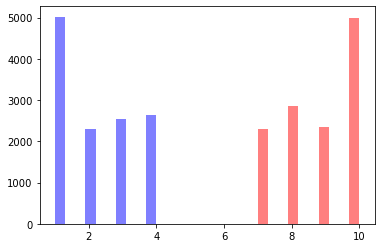

In [31]:
# Get some insight about the data
print('Negative summary')
print(test_data[test_data['label'] == 'negative'].describe())
print('Positive summary')
print(test_data[test_data['label'] == 'positive'].describe())
plt.hist(test_data[test_data['label'] == 'negative']['rate'], facecolor='b', alpha=0.5, label='negative')
plt.hist(test_data[test_data['label'] == 'positive']['rate'], facecolor='r', alpha=0.5, label='positive')
plt.show()

In [34]:
# Retrieve English stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
# Create regex to filter html tags if any
html_regex = re.compile('<.*?>')
# Create stemmer
stemmer = nltk.PorterStemmer()
# Create lemmatizer
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()

# Perform the clean up process on an input dataset
def clean (data):
    print('Processing started')
    # 1. Remove html tags
    print('Removing tags', end='...')
    data['review_processed'] = data['review'].apply(lambda x: re.sub(html_regex, ' ', x))
    print('OK')
    # 2. Remove punctuation
    print('Removing punctuation', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    print('OK')
    # 3. Tokenize
    print('Tokenizing', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: re.split('\W+', x.lower()))
    print('OK')
    # 4. Remove stop words
    print('Removing stop words', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: [word for word in x if word not in stopwords])
    print('OK')
    # 5. Apply stemming or lemmatization
    print('Stemming', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    #print('Lemmatization', end='...')
    #data['review_processed'] = data['review_processed'].apply(lambda x: ' '.[lemmatizer.lemmatize(word) for word in x]))
    print('OK')
    # 6. Replace input data with processed data
    data.drop(columns=['review'], axis=1, inplace=True)
    data.rename(columns={'review_processed': 'review'}, inplace=True)
    print('Processing finished')
    
# Process train dataset
clean(train_data)
train_data.head()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11002]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11002]
[nltk_data]     getaddrinfo failed>


Processing started
Removing tags...OK
Removing punctuation...OK
Tokenizing...OK
Removing stop words...OK
Stemming...OK
Processing finished


,label,rate,review
971,positive,8,australia first mainstream slasher film hit sc...
237,negative,1,lot peopl seem like film feel somewhat bad giv...
3515,negative,4,aint bad aint good entertain comedi suppo drea...
3804,positive,8,think truli love film prix de beaut origin sil...
11431,negative,4,nobl effort guess ultim poor one see film felt...


In [35]:
# Process test dataset
clean(test_data)
test_data.head()

Processing started
Removing tags...OK
Removing punctuation...OK
Tokenizing...OK
Removing stop words...OK
Stemming...OK
Processing finished


,label,rate,review
2818,negative,1,realli bad wast time would probabl rather go w...
2917,negative,3,ive seen seri sinc leav tv background nois dor...
8436,positive,8,reserv watch return lonesom dove see enjoy ori...
10963,negative,2,movi vampir turn isnt even realli worth 2 10 i...
1559,negative,1,yesterday one day decid go movi pick ik ook va...


In [36]:
# Save processed data so that we can skip previous steps and start over from next step
# when we are satisfied enough with our preprocessing
# SKIP if already saved
print('Saving test data', end='...')
test_data.to_pickle('test_data.pkl')
print('OK:', test_data.shape)
print('Saving train data', end='...')
train_data.to_pickle('train_data.pkl')
print('OK:', train_data.shape)

Saving test data...OK: (25000, 3)
Saving train data...OK: (25000, 3)


In [12]:
# Load processed data
# SKIP if already loaded
print('Loading test data', end='...')
test_data = pd.read_pickle('test_data.pkl')
print('OK', test_data.shape)
print(test_data.groupby('label').count())
print('Loading train data', end='...')
train_data = pd.read_pickle('train_data.pkl')
print('OK', train_data.shape)
print(train_data.groupby('label').count())

Loading test data...OK (25000, 3)
           rate  review
label                  
negative  12500   12500
positive  12500   12500
Loading train data...OK (25000, 3)
           rate  review
label                  
negative  12500   12500
positive  12500   12500


In [20]:
# Simplify data for testing purpose
# SKIP to handle all data
test_data = test_data.head(100)
train_data = test_data.head(100)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We can select the most important features (ie words) using term frequency-inverse document frequency method
vectorizer = TfidfVectorizer(max_features=50)
train_tfidf = vectorizer.fit_transform(train_data['review'])
print(dict(zip(vectorizer.get_feature_names(), vectorizer.idf_)))
# Filter words according to feature selection in reviews if we'd like
#train_data['review'] = train_data['review'].apply(lambda x: [word for word in x if word in vectorizer.get_feature_names()])

{'act': 2.327914520190518, 'actor': 2.616099787943009, 'also': 2.359809281380557, 'bad': 2.4603684890462807, 'charact': 2.1009749832377764, 'come': 2.5299276328761127, 'could': 2.4519614737591384, 'dont': 2.376304824682734, 'end': 2.3265571562840512, 'even': 2.0808516632426244, 'film': 1.5253703091688937, 'first': 2.375354856276904, 'get': 2.024361475287882, 'go': 2.3344252555824827, 'good': 1.9610143387008163, 'great': 2.3758297276748266, 'know': 2.508004942703488, 'like': 1.703884189308302, 'littl': 2.6457270443092424, 'look': 2.311301102089699, 'love': 2.456756824616458, 'made': 2.39808310735446, 'make': 1.9692042206812446, 'mani': 2.59715416194529, 'movi': 1.4407800153993242, 'much': 2.2681602900164313, 'never': 2.61268304258307, 'one': 1.5696253181729345, 'peopl': 2.3890580662415086, 'play': 2.4906287777957408, 'plot': 2.586152086330625, 'realli': 2.189189874634319, 'say': 2.5078242579076218, 'scene': 2.349115649837304, 'see': 1.9909465244549662, 'seem': 2.5748832668696227, 'seen'

# Exploration & Visualization

Counting words...OK
Most frequent word is film  - Least frequent word is überspi
Counting words...OK
Most frequent word is movi  - Least frequent word is üvegtigri
Counting words...OK
Most frequent word is best  - Least frequent word is film
Counting words...OK
Most frequent word is way  - Least frequent word is movi
Counting words...OK
Most frequent word is seri  - Least frequent word is film
Counting words...OK
Most frequent word is horror  - Least frequent word is movi


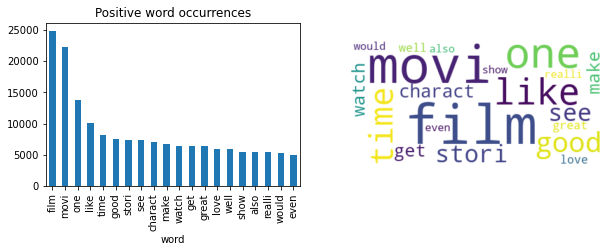

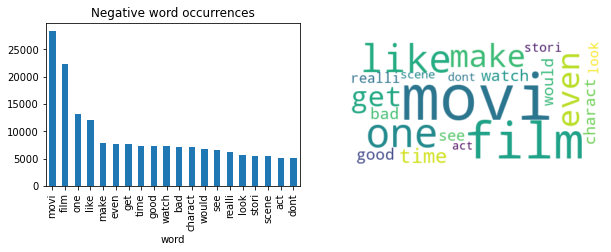

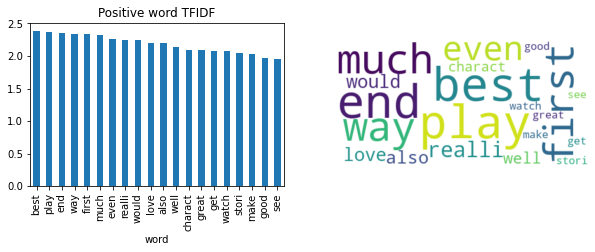

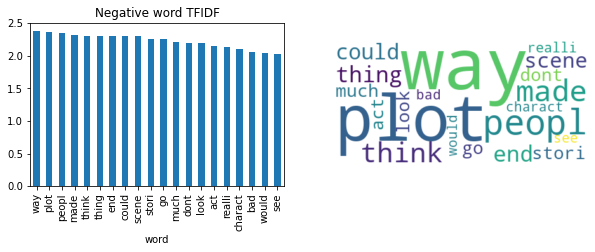

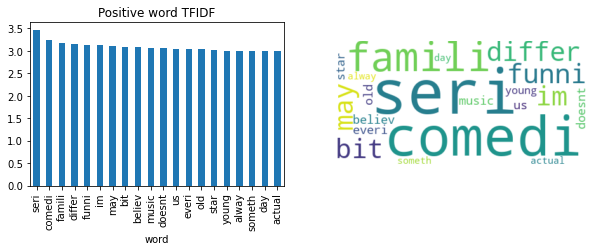

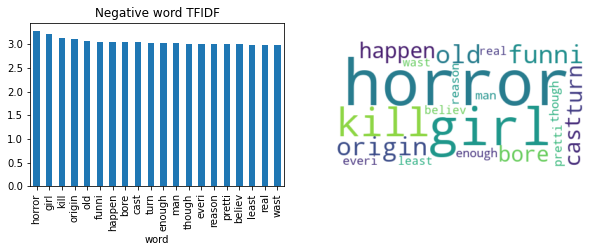

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Perform a full vectorization of labelled data
def words2frequency (data, tfidf=False, **kwargs):
    print('Counting words', end='...')
    # Count occurences or term frequency-inverse document frequency
    if (tfidf == False):
        vectorizer = CountVectorizer()
        counts = vectorizer.fit_transform(data['review'])
        # Create a data frame to handle word occurrences
        frequencies = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': counts.toarray().sum(axis=0)})
    else:
        vectorizer = TfidfVectorizer(**kwargs)
        counts = vectorizer.fit_transform(data['review'])
        # Create a data frame to handle word frequencies
        frequencies = pd.DataFrame({'word': vectorizer.get_feature_names(), 'frequency': vectorizer.idf_})
    frequencies.sort_values(by=['frequency'], ascending=False, inplace=True)
    print('OK')
    print('Most frequent word is', frequencies['word'].iloc[0], ' - Least frequent word is', frequencies['word'].iloc[-1])
    return frequencies

# Display a distribution plot and a word cloud
def display_frequency (frequencies, title):
    figure, axes = plt.subplots(1, 2, figsize=(10,3))
    frequencies.plot(x='word', y='frequency', kind='bar', legend=False, subplots=True, ax=axes[0], sharex=False, sharey=False)
    axes[0].title.set_text(title)
    wordcloud = WordCloud(background_color='white').fit_words(dict(frequencies.values.tolist()))
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis("off")

# Display statistics about N most used words in positive/negative reviews using occurrences counting
positive_frequencies = words2frequency(train_data[train_data['label'] == 'positive'])
display_frequency(positive_frequencies.head(20), 'Positive word occurrences')
negative_frequencies = words2frequency(train_data[train_data['label'] == 'negative'])
display_frequency(negative_frequencies.head(20), 'Negative word occurrences')
# Then using TFIDF as feature selector
positive_frequencies = words2frequency(train_data[train_data['label'] == 'positive'], tfidf=True, max_df=0.75, min_df=0.25)
display_frequency(positive_frequencies.head(20), 'Positive word TFIDF')
negative_frequencies = words2frequency(train_data[train_data['label'] == 'negative'], tfidf=True, max_df=0.75, min_df=0.25)
display_frequency(negative_frequencies.head(20), 'Negative word TFIDF')
# Using a different feature selection tuning
positive_frequencies = words2frequency(train_data[train_data['label'] == 'positive'], tfidf=True, max_features=100)
display_frequency(positive_frequencies.head(20), 'Positive word TFIDF')
negative_frequencies = words2frequency(train_data[train_data['label'] == 'negative'], tfidf=True, max_features=100)
display_frequency(negative_frequencies.head(20), 'Negative word TFIDF')


It appears that raw word occurrences does not give much information to easily separate negative and positive reviews. For instance, the most used words in both cases are *film, movie, one*, etc. which are more related to the context of reviewing than the sentiment of the reviewer. When performing feature engineering it seems to provide better discriminants. For instance we can see *best, love, well, great, good* words for positive reviews and *don't, bad* words for negative ones, which are more related to the author sentiment.

We can also see some movie gender appear in the negative ones like *act(ion)*. In the positive ones *love* might also refer to love stories instead of the author sentiment. If we play with the feature selection tuning we can find more genders like *comedi(e)*, *famili(y)* for positive ones and *horror* for negative ones.

# Model Building

## Supervised learning

Building predictive random forest model...OK
0.84524
              precision    recall  f1-score   support

    negative       0.85      0.84      0.85     12500
    positive       0.84      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



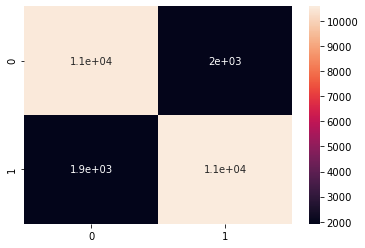

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('Building predictive random forest model', end='...')
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['review'])
X_test = vectorizer.transform(test_data['review'])
y_train = train_data['label']
y_test = test_data['label']

# Fit a predictive model based on a random forest
model = RandomForestClassifier()
# We can use a grid search to optimize hyperparameters but it is far more long
hyperparameters = {
 'n_estimators': [10, 150, 300],
 'max_depth': [30, 60, 90, None]
}
#grid = GridSearchCV(model, hyperparameters, cv=5, n_jobs=-1)
#grid = grid.fit(X_train, y_train)
#results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
#model = RandomForestClassifier(n_estimators=results['param_n_estimators'].iloc[0],
#                               max_depth=results['param_max_depth'].iloc[0])
model.fit(X_train, y_train)
# Predict the outcome for testing data
predictions = model.predict(X_test)
print('OK')

# Then evaluate the model
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions))
sn.heatmap(matrix, annot=True)

Building predictive logistic regression model...OK
0.87624
              precision    recall  f1-score   support

    negative       0.88      0.87      0.88     12500
    positive       0.87      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



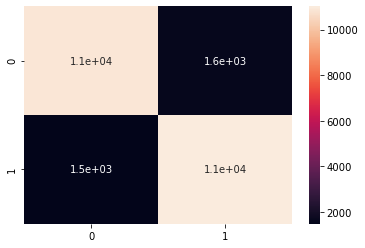

In [51]:
# Now we can try to use another model like Logistic Regression to check if it is better
from sklearn.linear_model import LogisticRegression

print('Building predictive logistic regression model', end='...')
model = LogisticRegression()
model.fit(X_train, y_train)
# Predict the outcome for testing data
predictions = model.predict(X_test)
print('OK')

# Then evaluate the model
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
matrix = pd.DataFrame(confusion_matrix(y_test, predictions))
sn.heatmap(matrix, annot=True)

The logistic regression model has better accuracy results than the random forest one and a more consistent behaviour in terms of false positives or false negatives. As we have used a single holdout for validation, we should ideally train the model again with the same hyperparameters when satisfied but on the whole data set (train + test data).

## Unsupervised learning

In [44]:
unlabelled_reviews = [open(filename, 'r', encoding='utf-8').read() for filename in glob.glob('aclImdb/train/unsup/*.txt')]
unlabelled_data = pd.DataFrame({ 'review': unlabelled_reviews })
# Process test dataset
clean(unlabelled_data)
unlabelled_data.head()

Processing started
Removing tags...OK
Removing punctuation...OK
Tokenizing...OK
Removing stop words...OK
Stemming...OK
Processing finished


,review
0,admit great major film releas say 1933 dozen m...
1,take low budget inexperienc actor doubl produc...
2,everybodi seen back futur right whether like m...
3,dori day icon beauti sing act warm voic geniu ...
4,seri silli funlov movi 1955 big year dori day ...


In [45]:
# Save processed data so that we can skip previous steps and start over from next step
# when we are satisfied enough with our preprocessing
print('Saving unlabelled data', end='...')
unlabelled_data.to_pickle('unlabelled_data.pkl')
print('OK:', unlabelled_data.shape)

Saving unlabelled data...OK: (50000, 1)


In [3]:
# Load processed data
# SKIP if already loaded
print('Loading unlabelled data', end='...')
unlabelled_data = pd.read_pickle('unlabelled_data.pkl')
print('OK', unlabelled_data.shape)

Loading unlabelled data...OK (50000, 1)


In [37]:
# Simplify data for testing purpose
# SKIP to handle all data
unlabelled_data = unlabelled_data.head(100)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Perform clustering using K-Means
print('Clustering unlabelled data with K-Means', end='...')
vectorizer = TfidfVectorizer(max_features=100)
X_train = vectorizer.fit_transform(unlabelled_data['review'])
model = KMeans(n_clusters=2)
model.fit(X_train)
# Create a column cluster to denote the generated cluster for each review
unlabelled_data['label'] = model.labels_.tolist()
print('OK')
unlabelled_data['label'].value_counts()

Clustering unlabelled data with K-Means...OK


1    30380
0    19620
Name: label, dtype: int64

Counting words...OK
Most frequent word is thing  - Least frequent word is one
Counting words...OK
Most frequent word is first  - Least frequent word is one


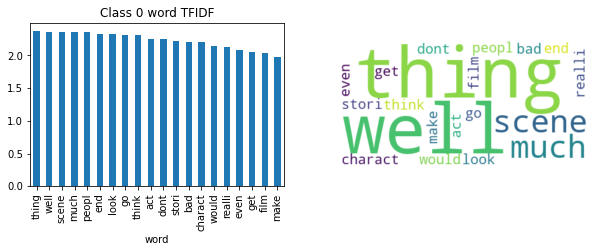

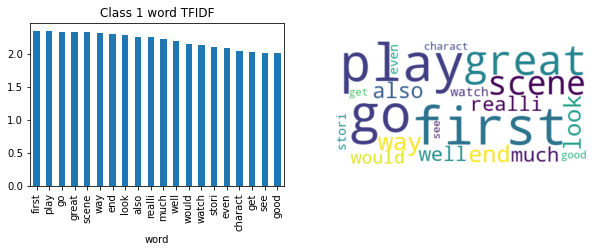

In [55]:
# Display statistics about N most used words in each class using TFIDF
# in order to see if our clusters seem to reflect positive/negative reviews
frequencies = words2frequency(unlabelled_data[unlabelled_data['label'] == 0], tfidf=True, max_df=0.75, min_df=0.25)
display_frequency(frequencies.head(20), 'Class 0 word TFIDF')
frequencies = words2frequency(unlabelled_data[unlabelled_data['label'] == 1], tfidf=True, max_df=0.75, min_df=0.25)
display_frequency(frequencies.head(20), 'Class 1 word TFIDF')

As we can see our class 0 seems to have a lot in common with the negative reviews while the class 1 has a lot in common with the positive ones. However, the distribution is screwed as we don't have the same amount of movies in each class. As we don't really know the distribution of reviews according to the rating it's hard to say if it is right or not. Indeed, the labelled data has been intentionnally balanced (25k pos and 25k neg) but maybe in real life there are more "bad" movies than "good" movies.

Clustering unlabelled data with hierarchical method...OK


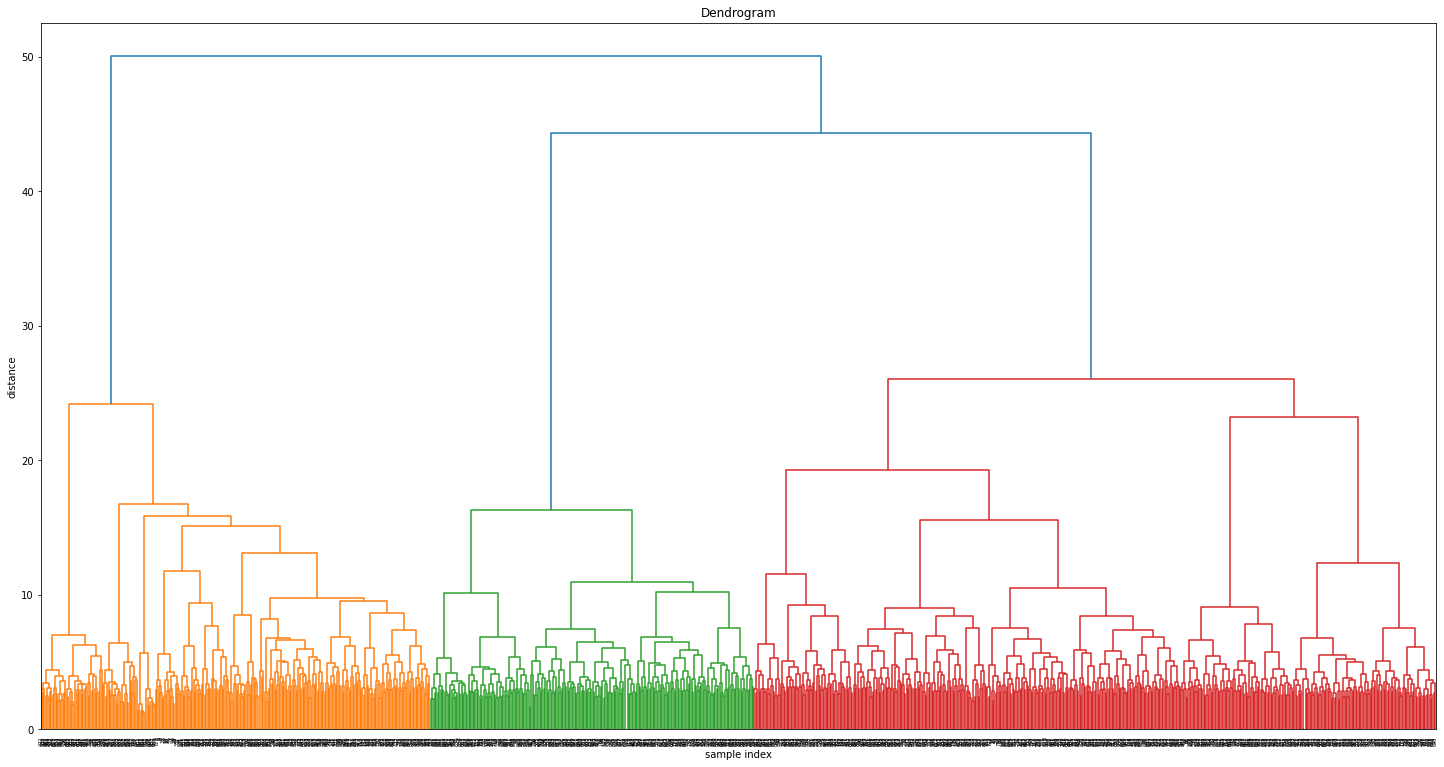

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
print('Clustering unlabelled data with hierarchical method', end='...')
# WARNING: if the matrix is too much large the process fails on my computer
# with the following error: "nnz of the result is too large"
# So I must reduce the number of samples to make it work
X_train = vectorizer.fit_transform(unlabelled_data.head(1000)['review'])
# Pre-computed distances for linkage
distances = 1 - cosine_similarity(X_train)
# Generate the linkage matrix using ward clustering
Z = linkage(distances, 'ward')
print('OK')

plt.figure(figsize=(25, 13))
plt.title('Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z)
plt.show()

It appears that we have 3 clusters but as my computer is not able to work with the whole dataset this might be biased.

## Finding more classes

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Perform clustering using K-Means
# We will use the Elbow method to find the optimal number of classes we can have
print('Clustering unlabelled data with K-Means and Elbow method', end='...')
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(unlabelled_data['review'])
inertia = []
K = range(1,10)
for k in K:
    print('k={}'.format(k), end='...')
    model = KMeans(n_clusters=k)
    model.fit(X_train)
    inertia.append(model.inertia_)
print('OK')

Clustering unlabelled data with K-Means and Elbow method...k=1...k=2...k=3...k=4...k=5...k=6...k=7...k=8...k=9...OK


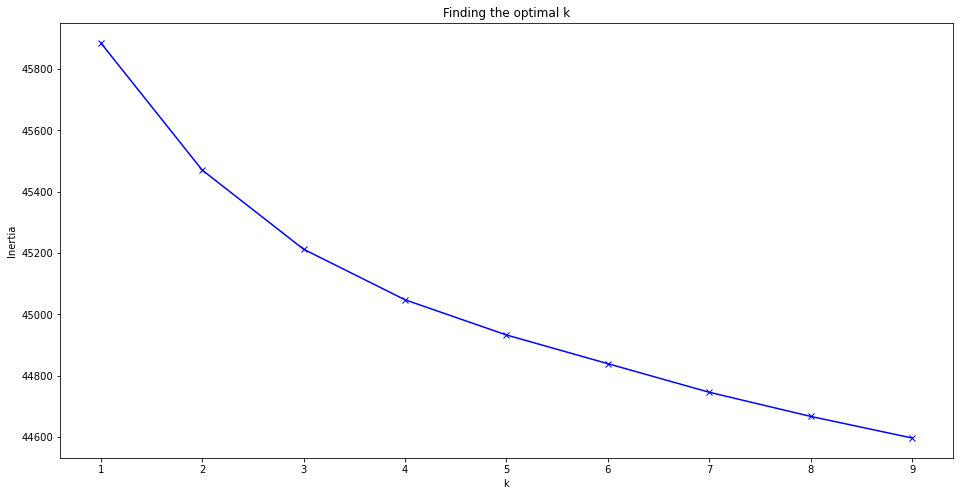

In [46]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Finding the optimal k')
plt.show()

In [37]:
print('Clustering unlabelled data with K-Means', end='...')
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(unlabelled_data['review'])
# It appears the best number of clusters seems to be 5 in our case
model = KMeans(n_clusters=5)
model.fit(X_train)
# Create a column cluster to denote the generated cluster for each review
unlabelled_data['label'] = model.labels_.tolist()
print('OK')
unlabelled_data['label'].value_counts()

Clustering unlabelled data with K-Means...OK


1    16104
0    11449
3    10074
2     9877
4     2496
Name: label, dtype: int64

Counting words...OK
Most frequent word is kid  - Least frequent word is movi
Counting words...OK
Most frequent word is war  - Least frequent word is film
Counting words...OK
Most frequent word is horror  - Least frequent word is film
Counting words...OK
Most frequent word is horror  - Least frequent word is movi
Counting words...OK
Most frequent word is famili  - Least frequent word is show


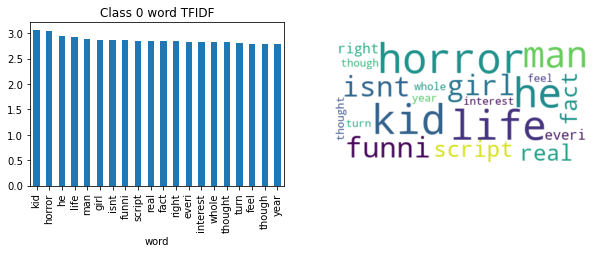

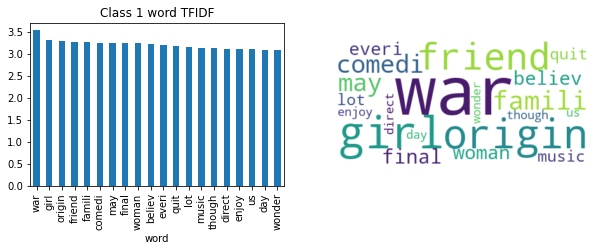

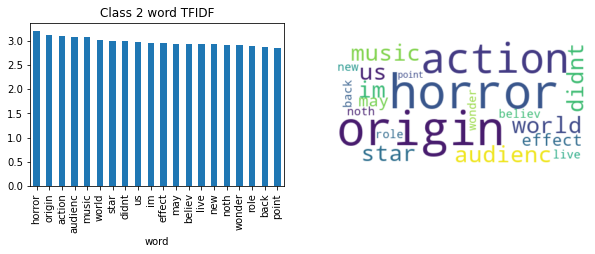

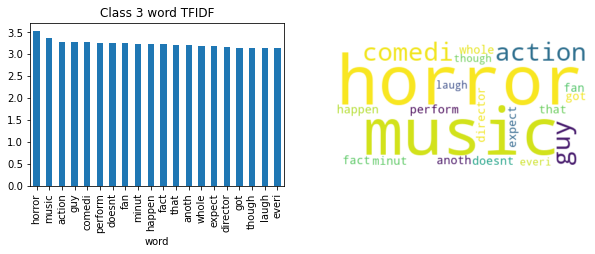

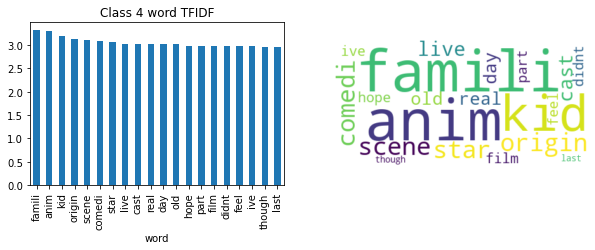

In [44]:
# Display statistics about N most used words in each class using TFIDF
# in order to see if we can identify our clusters
for i in range(5):
    frequencies = words2frequency(unlabelled_data[unlabelled_data['label'] == i], tfidf=True, max_features=100)
    display_frequency(frequencies.head(20), 'Class {} word TFIDF'.format(i))


It appears the clusters are more related to a gender than a sentiment. For instance the class 4 seems to be dedicated to movies for the *famili(y)*, *kid(s)* which are *comedi(es)* or *anim(ated)*. The class 2 is for violent movies like *horror* or *act(ion)*. The class 3 is probably for second degree humour movies like *comedi(e)* but that can also be found in some *horror* or *act(ion)* movies and where music seems to play a role. Others classes are a little more hard to interpret in my humble opinion.